# import

In [1]:
import numpy as np

from sklearn import datasets
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

import math

import matplotlib.pyplot as plt

from scipy.spatial import distance

mbyte = 1048576
norm_l1 = Normalizer(norm='l1')
norm_l2 = Normalizer(norm='l2')

# Tools

In [2]:
from hashlib import md5

def generate_md5(H):
    hmd5 = md5()
    hmd5.update(str(H).encode(encoding='utf-8'))
    return hmd5.hexdigest()

# Datasets

- SIFT
- MNIST
- GLOVE

In [3]:
%store -r Datasets

In [4]:
Datasets.keys()

dict_keys(['SIFT-10K'])

In [5]:
data = Datasets['SIFT-10K']
data.keys()

dict_keys(['title', 'train', 'test', 'K', 'n_train', 'n_test', 'k_near_neighbors', 'nearest_neighbor'])

In [6]:
train = data['train']
test = data['test']
K = data['K']
d = train.shape[1]
k_near_neighbors = data['k_near_neighbors']

In [7]:
train[:10]

array([[ 0, 16, 35, ..., 25, 23,  1],
       [14, 35, 19, ..., 11, 21, 33],
       [ 0,  1,  5, ...,  4, 23, 10],
       ...,
       [16, 36, 10, ...,  3,  7, 41],
       [ 8, 35, 11, ..., 17,  4,  7],
       [21, 13, 18, ..., 51, 36,  3]])

# Metrics

In [8]:
def metrics(P, query_func, args, test, exact_near_neighbors):
    """
    
    """
    pass

# Desc

In [9]:
rand = np.random.RandomState(1)

## Step 1: center the mean

In [10]:
center = train.mean(axis=0)
center.shape

(128,)

In [11]:
train_center = train - center
test_center = test - center

**计算 $k = 200$**

In [12]:
%%time
K = 200
k_near_neighbors = []
for i, q in enumerate(test_center):
    dis = np.array([distance.euclidean(q, p) for p in train_center])
    order_dis = dis.argsort()
    k_near_neighbors.append(order_dis[:K])

CPU times: user 14.7 s, sys: 13.5 ms, total: 14.8 s
Wall time: 14.8 s


## Step 2: 50 PNs $\rightarrow$ 2000 KCs

In [13]:
k = 10

In [14]:
m = 10 * d

**m * d**
$$
M_{ji} = 
\begin{cases}
1, & \text{if $x_i$ connects to $y_i$} \\
0, & \text{otherwise}
\end{cases}
$$

$$
x = (x_1, ..., x_d) \in \mathbb R^d \\
y = (y_1, ..., y_m) \in \mathbb R^m \\
d << m
$$

$$
y = Mx
$$

**for discretization**
$$
y = \lfloor\frac{Mx}{w}\rfloor
$$

In [15]:
%%time
M = rand.choice([0, 1], p=[1-k/d, k/d], size=(m, d))
M.shape

CPU times: user 6.16 ms, sys: 24 µs, total: 6.18 ms
Wall time: 5.59 ms


In [16]:
%%time
H = train_center.dot(M.T)

CPU times: user 124 ms, sys: 59.6 ms, total: 183 ms
Wall time: 134 ms


## Step 3: Winner-Take-All

- **winner-take-all**

取 2000 个中 $k$ highest

$$
z_i = 
\begin{cases}
y_i, & \text{if $y_i$ is one of the $k$ largest entries in $y$} \\
0, & \text{otherwise}
\end{cases}
$$

each entry $M_{ij}$ is set independently with probability $p$, $p = \frac{6}{d}$

# Condition

- 10000 points, 1000 random query input from it.
- metric: precision, 2%(200)

# Sparse binary vs. dense Gaussian random projections

## E2LSH

In [17]:
w = 500
k = 12

In [18]:
A = rand.normal(0, 1, (k, d))
B = rand.uniform(0, w, (k))

In [19]:
(train_center.dot(A.T) + B) // w

array([[ 1.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0., -1.,  0., ..., -1.,  0.,  0.],
       [ 1., -1.,  0., ..., -1.,  1.,  0.],
       ...,
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0., -1., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [20]:
e2lsh_H = (train_center.dot(A.T) + B) // w

In [21]:
%%time

e2lsh_precision = []

for i, q in enumerate(test_center):
    h = (q.dot(A.T) + B) // w
    dis = np.array([distance.euclidean(h, p_h) for p_h in e2lsh_H])
    correct = len(np.intersect1d(dis.argsort()[:K], k_near_neighbors[i]))
    e2lsh_precision.append(correct / K)

print(np.array(e2lsh_precision).mean())

0.19770000000000004
CPU times: user 13.6 s, sys: 16.6 ms, total: 13.6 s
Wall time: 13.4 s


## FLY

In [22]:
d = train_center.shape[1]

### metrics

In [23]:
def test_precision(train, test, s, m, k=4, near_neighbors=None, K=200, 
                   wta=False, use_indices=False,
                   random_state=None, verbose=False):
    
    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)

    M = rand.choice([0, 1], p=[1-s/d, s/d], size=(m, d))
    H = train_center.dot(M.T)
    
    if wta is True:
        H_order = H.argsort(axis=1)
        for i, h in enumerate(H_order[:, :-k]):
            H[i][h] = 0
            if use_indices is True:
                H[i][H[i] != 0] = 1
    
    # print(H[0])
    
    precision = []
    for i, q in enumerate(test):
        h = M.dot(q)
        
        if wta is True:
            h[h.argsort()[:-k]] = 0
        
            if use_indices is True:
                h[h != 0] = 1

        # if i == 0:
            # print(h)
        dis = np.array([distance.euclidean(h, h_) for h_ in H])
        precision.append(len(np.intersect1d(dis.argsort()[:K], near_neighbors[i])) / K)
    
    result = np.array(precision).mean()

    if verbose is True:
        print('s = {}, m = {}, k = {}, preicison = {}'.format(s, m, k, result))
        
    return result

In [24]:
test_precision(train_center, test_center, s=4, m=2000, k=4, near_neighbors=k_near_neighbors, wta=False, random_state=1)

0.8751000000000001

### test: sparse binary

$$
m = 
\begin{cases}
10 \times d \\
20 \times k
\end{cases}
$$

#### fixed $m = 10 \times d$

In [25]:
s_arr = np.floor(np.array([0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]) * d).astype(np.int)
s_arr

array([ 1,  3,  6,  8, 12, 25, 38, 51, 64])

In [26]:
np.arange(2, 66, 2)

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64])

In [27]:
%%time
m = 10 * d
precision_s_1 = []
for s in s_arr:
    precision_s_1.append(test_precision(train_center, test_center, 
                                        s, m,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 5min 58s, sys: 14.8 s, total: 6min 13s
Wall time: 3min 17s


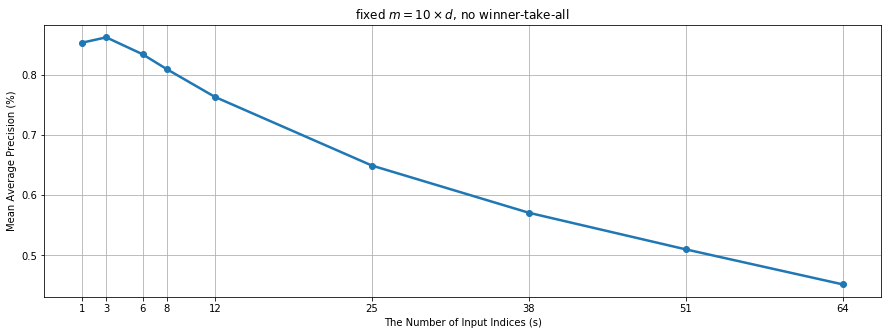

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(s_arr, precision_s_1, 'o-', linewidth=2.5)
plt.xticks(s_arr)
plt.grid()
plt.title('fixed $m = 10 \\times d$, no winner-take-all')
plt.xlabel('The Number of Input Indices (s)')
plt.ylabel('Mean Average Precision (%)')
plt.show()

####  fixed $m = 20 \times k, k = 4$

In [29]:
k = 4
m = 20 * k

In [30]:
%%time
precision_s_2 = []
for s in s_arr:
    precision_s_2.append(test_precision(train_center, test_center, 
                                        s, m, k,
                                        near_neighbors=k_near_neighbors, random_state=2))

CPU times: user 4min 37s, sys: 11.3 s, total: 4min 48s
Wall time: 2min 26s


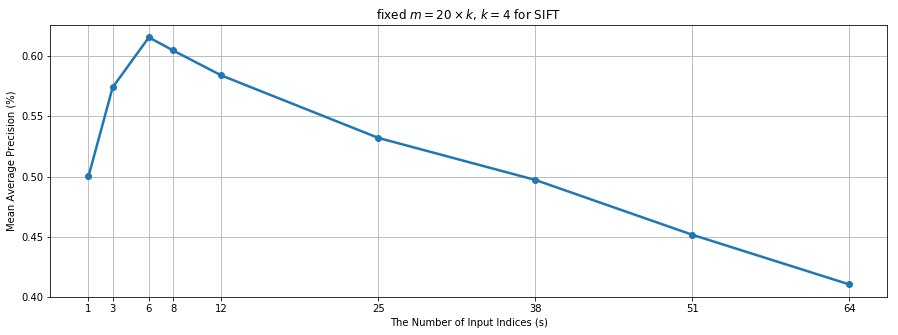

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(s_arr, precision_s_2, 'o-', linewidth=2.5)
plt.xticks(s_arr)
plt.grid()
plt.title('fixed $m = 20 \\times k$, $k = 4$ for SIFT')
plt.xlabel('The Number of Input Indices (s)')
plt.ylabel('Mean Average Precision (%)')
plt.show()

#### fixed $s = 12$, $m$ from $10$ to $30 \times d$, $k = 4$

In [32]:
s = 12
m_arr_1 = np.arange(2, 32, 2) * d
k = 4

In [33]:
%%time
precision_m_1 = []
for m in m_arr_1:
    precision_m_1.append(test_precision(train_center, test_center, 
                                        s, m, k,
                                        near_neighbors=k_near_neighbors, random_state=2))

CPU times: user 10min 13s, sys: 24.2 s, total: 10min 37s
Wall time: 5min 42s


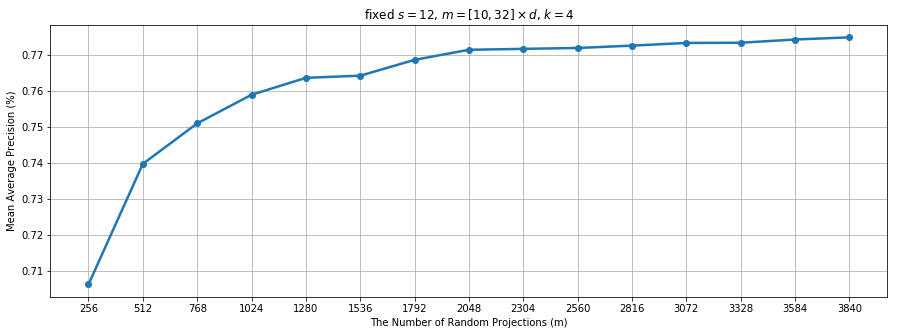

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_1, precision_m_1, 'o-', linewidth=2.5)
plt.xticks(m_arr_1)
plt.grid()
plt.title('fixed $s = 12$, $m = [10, 32] \\times d$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.show()

#### fixed $s = 12$, $m$ from $2$ to $30 \times k$, $k = 4$

In [35]:
s = 12
k = 4
m_arr_2 = np.arange(2, 32, 2) * k

In [36]:
%%time
precision_m_2 = []
for m in m_arr_2:
    precision_m_2.append(test_precision(train_center, test_center, 
                                        s, m, k,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 6min 31s, sys: 14 s, total: 6min 45s
Wall time: 3min 42s


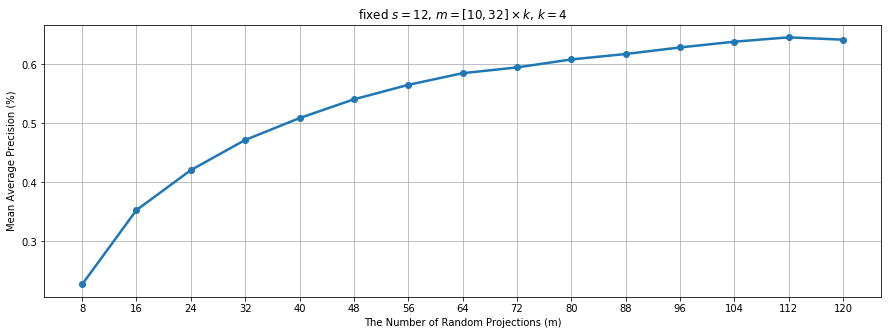

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_2, precision_m_2, 'o-', linewidth=2.5)
plt.xticks(m_arr_2)
plt.grid()
plt.title('fixed $s = 12$, $m = [10, 32] \\times k$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.show()

#### fixed $s = 12$, $m$ from $100$ to $5000$, $k = 4$

In [38]:
s = 12
k = 4
m_arr_3 = np.arange(100, 5300, 300)
m_arr_3

array([ 100,  400,  700, 1000, 1300, 1600, 1900, 2200, 2500, 2800, 3100,
       3400, 3700, 4000, 4300, 4600, 4900, 5200])

In [39]:
%%time
precision_m_3 = []
for m in m_arr_3:
    precision_m_3.append(test_precision(train_center, test_center, 
                                        s, m, k,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 12min 2s, sys: 28.2 s, total: 12min 30s
Wall time: 6min 41s


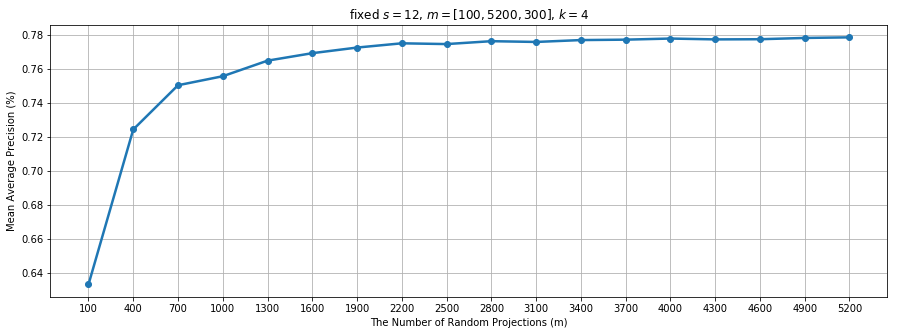

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_3, precision_m_3, 'o-', linewidth=2.5)
plt.xticks(m_arr_3)
plt.grid()
plt.title('fixed $s = 12$, $m = [100, 5200, 300]$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.show()

#### fixed $s = 4$, $m$ from $100$ to $5000$, $k = 4$

In [41]:
s = 4
k = 4
m_arr_4 = np.arange(100, 5300, 300)
m_arr_4

array([ 100,  400,  700, 1000, 1300, 1600, 1900, 2200, 2500, 2800, 3100,
       3400, 3700, 4000, 4300, 4600, 4900, 5200])

In [42]:
%%time
precision_m_4 = []
for m in m_arr_4:
    precision_m_4.append(test_precision(train_center, test_center, 
                                        s, m, k,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 12min 1s, sys: 27.8 s, total: 12min 28s
Wall time: 6min 40s


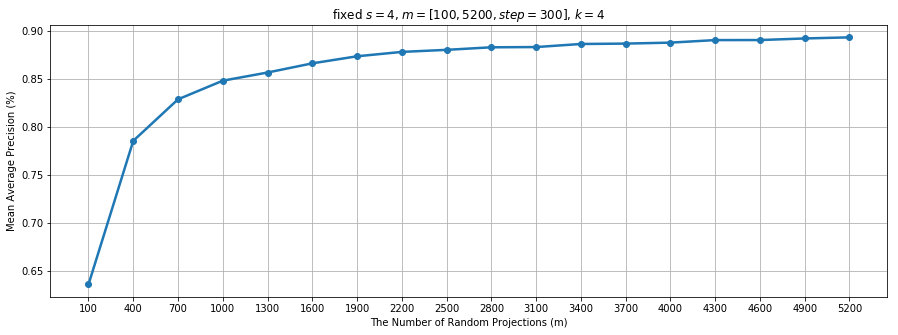

In [43]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_4, precision_m_4, 'o-', linewidth=2.5, label='s=4')
plt.xticks(m_arr_4)
plt.grid()
plt.title('fixed $s = 4$, $m = [100, 5200, step=300]$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.show()

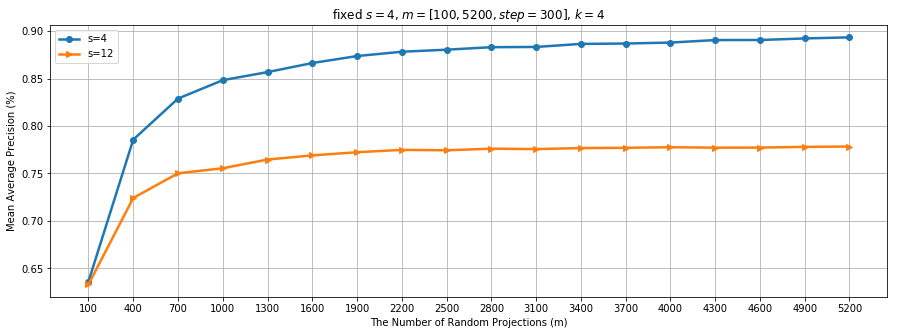

In [44]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_4, precision_m_4, 'o-', linewidth=2.5, label='s=4')
plt.plot(m_arr_3, precision_m_3, '>-', linewidth=2.5, label='s=12')
plt.xticks(m_arr_4)
plt.grid()
plt.title('fixed $s = 4$, $m = [100, 5200, step=300]$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

---

### test: winner-take-all TYPE 1

**when**
$$
z_i = 
\begin{cases}
y_i, & \text{if $y_i$ is one of the $k$ largest entries in $y$} \\
0, & \text{otherwise}
\end{cases}
$$

#### fixed $m = 10 \times d$

In [45]:
s_arr = np.floor(np.array([0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]) * d).astype(np.int)
s_arr

array([ 1,  3,  6,  8, 12, 25, 38, 51, 64])

In [46]:
%%time
m = 10 * d
precision_wta_s_1 = []
for s in s_arr:
    precision_wta_s_1.append(test_precision(train_center, test_center, 
                                        s, m, k=4, wta=True,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 5min 45s, sys: 14.2 s, total: 5min 59s
Wall time: 3min 3s


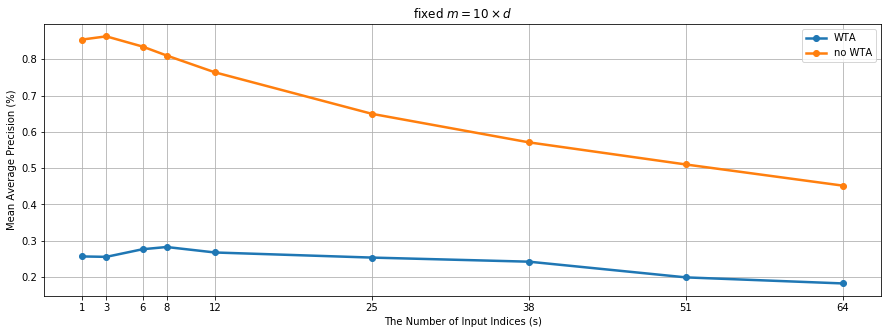

In [47]:
plt.figure(figsize=(15, 5))
plt.plot(s_arr, precision_wta_s_1, 'o-', linewidth=2.5, label='WTA')
plt.plot(s_arr, precision_s_1, 'o-', linewidth=2.5, label='no WTA')
plt.xticks(s_arr)
plt.grid()
plt.title('fixed $m = 10 \\times d$')
plt.xlabel('The Number of Input Indices (s)')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

####  fixed $m = 20 \times k, k = 4$

In [48]:
k = 4
m = 20 * k

In [49]:
%%time
precision_wta_s_2 = []
for s in s_arr:
    precision_wta_s_2.append(test_precision(train_center, test_center, 
                                        s, m, k, wta=True,
                                        near_neighbors=k_near_neighbors, random_state=2))

CPU times: user 4min 18s, sys: 10 s, total: 4min 28s
Wall time: 2min 14s


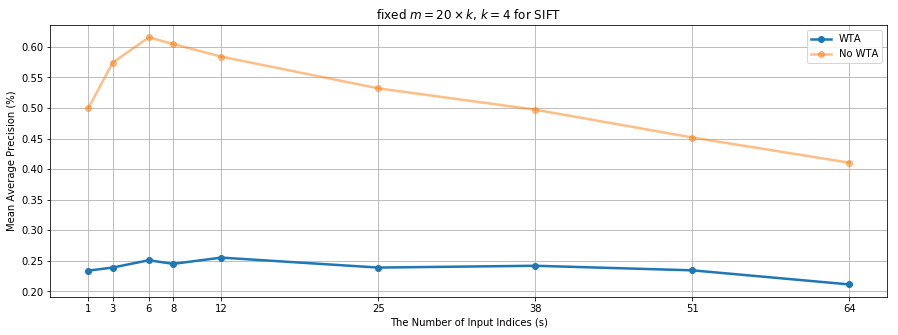

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(s_arr, precision_wta_s_2, 'o-', linewidth=2.5, label='WTA')
plt.plot(s_arr, precision_s_2, 'o-', linewidth=2.5, label='No WTA', alpha=0.5)
plt.xticks(s_arr)
plt.grid()
plt.title('fixed $m = 20 \\times k$, $k = 4$ for SIFT')
plt.xlabel('The Number of Input Indices (s)')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

#### fixed $s = 12$, $m$ from $10$ to $30 \times d$, $k = 4$

In [51]:
s = 12
m_arr_1 = np.arange(2, 32, 2) * d
k = 4

In [52]:
%%time
precision_wta_m_1 = []
for m in m_arr_1:
    precision_wta_m_1.append(test_precision(train_center, test_center, 
                                        s, m, k, wta=True,
                                        near_neighbors=k_near_neighbors, random_state=2))

CPU times: user 10min 2s, sys: 24.1 s, total: 10min 26s
Wall time: 5min 33s


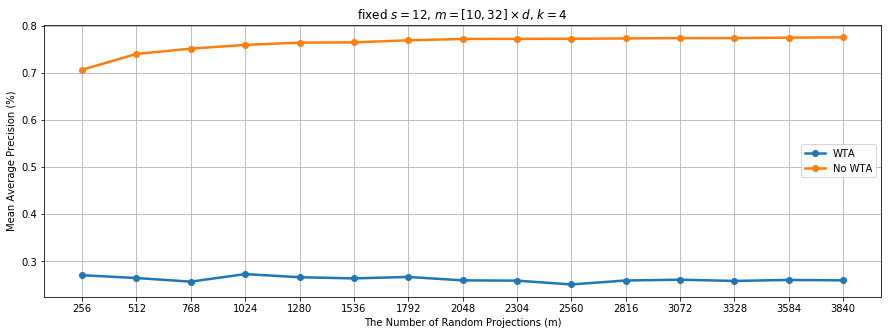

In [53]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_1, precision_wta_m_1, 'o-', linewidth=2.5, label='WTA')
plt.plot(m_arr_1, precision_m_1, 'o-', linewidth=2.5, label='No WTA')
plt.xticks(m_arr_1)
plt.grid()
plt.title('fixed $s = 12$, $m = [10, 32] \\times d$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

#### fixed $s = 12$, $m$ from $2$ to $30 \times k$, $k = 4$

In [54]:
s = 12
k = 4
m_arr_2 = np.arange(2, 32, 2) * k

In [55]:
%%time
precision_wta_m_2 = []
for m in m_arr_2:
    precision_wta_m_2.append(test_precision(train_center, test_center, 
                                        s, m, k, wta=True,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 6min 19s, sys: 13.4 s, total: 6min 32s
Wall time: 3min 34s


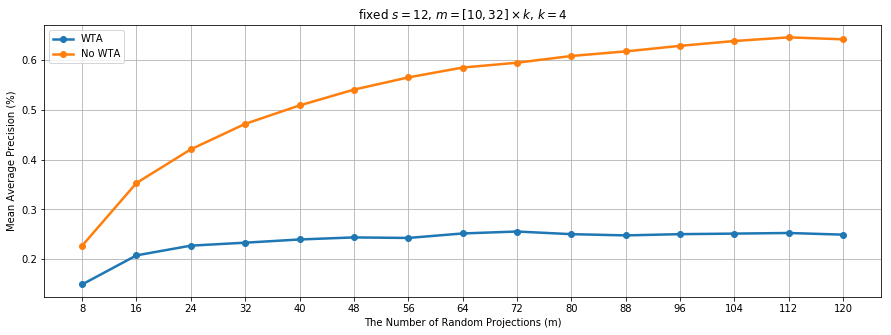

In [56]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_2, precision_wta_m_2, 'o-', linewidth=2.5, label='WTA')
plt.plot(m_arr_2, precision_m_2, 'o-', linewidth=2.5, label='No WTA')
plt.xticks(m_arr_2)
plt.grid()
plt.title('fixed $s = 12$, $m = [10, 32] \\times k$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

#### fixed $s = 12$, $m$ from $100$ to $5000$, $k = 4$

In [57]:
s = 12
k = 4
m_arr_3 = np.arange(100, 5300, 300)
m_arr_3

array([ 100,  400,  700, 1000, 1300, 1600, 1900, 2200, 2500, 2800, 3100,
       3400, 3700, 4000, 4300, 4600, 4900, 5200])

In [58]:
%%time
precision_wta_m_3 = []
for m in m_arr_3:
    precision_wta_m_3.append(test_precision(train_center, test_center, 
                                        s, m, k, wta=True,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 12min 28s, sys: 29.2 s, total: 12min 57s
Wall time: 7min 6s


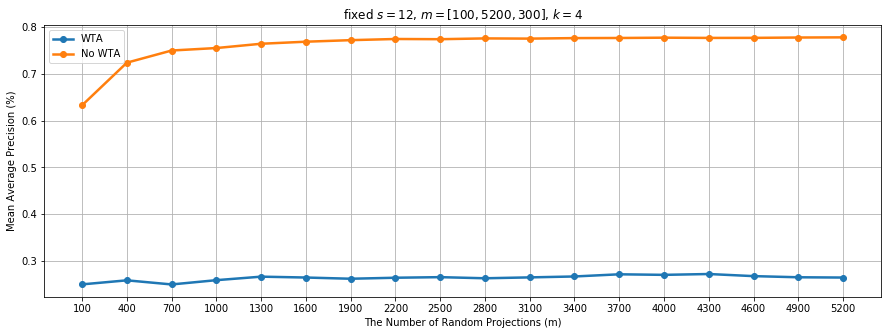

In [59]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_3, precision_wta_m_3, 'o-', linewidth=2.5, label='WTA')
plt.plot(m_arr_3, precision_m_3, 'o-', linewidth=2.5, label='No WTA')
plt.xticks(m_arr_3)
plt.grid()
plt.title('fixed $s = 12$, $m = [100, 5200, 300]$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

#### fixed $s = 4$, $m$ from $100$ to $5000$, $k = 4$

In [60]:
s = 4
k = 4
m_arr_4 = np.arange(100, 5300, 300)
m_arr_4

array([ 100,  400,  700, 1000, 1300, 1600, 1900, 2200, 2500, 2800, 3100,
       3400, 3700, 4000, 4300, 4600, 4900, 5200])

In [61]:
%%time
precision_wta_m_4 = []
for m in m_arr_4:
    precision_wta_m_4.append(test_precision(train_center, test_center, 
                                        s, m, k, wta=True,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 12min 31s, sys: 29.9 s, total: 13min
Wall time: 7min 9s


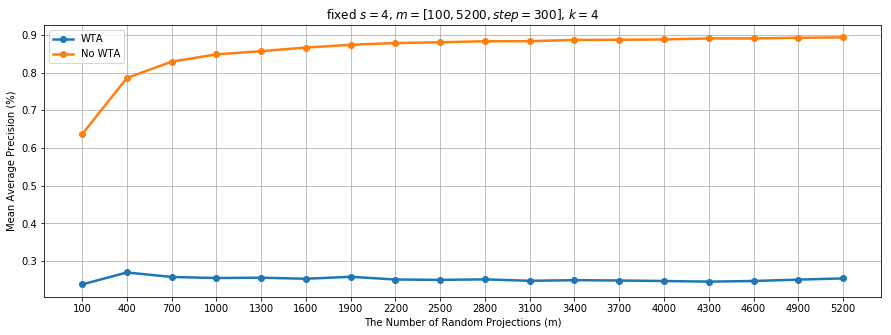

In [62]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_4, precision_wta_m_4, 'o-', linewidth=2.5, label='WTA')
plt.plot(m_arr_4, precision_m_4, 'o-', linewidth=2.5, label='No WTA')
plt.xticks(m_arr_4)
plt.grid()
plt.title('fixed $s = 4$, $m = [100, 5200, step=300]$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

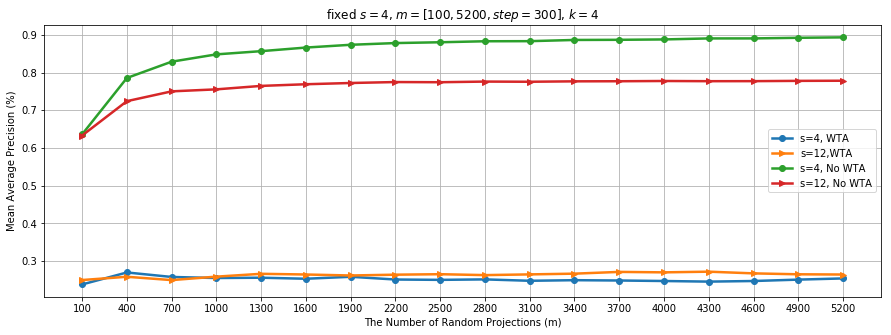

In [63]:
plt.figure(figsize=(15, 5))
plt.plot(m_arr_4, precision_wta_m_4, 'o-', linewidth=2.5, label='s=4, WTA')
plt.plot(m_arr_3, precision_wta_m_3, '>-', linewidth=2.5, label='s=12,WTA')
plt.plot(m_arr_4, precision_m_4, 'o-', linewidth=2.5, label='s=4, No WTA')
plt.plot(m_arr_3, precision_m_3, '>-', linewidth=2.5, label='s=12, No WTA')

plt.xticks(m_arr_4)
plt.grid()

plt.title('fixed $s = 4$, $m = [100, 5200, step=300]$, $k = 4$')
plt.xlabel('The Number of Random Projections (m)')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

#### fixed $s = 4$, $m = 20 \times k$, $k$ from $2$ to $64$

In [64]:
s = 4
k_arr_1 = np.arange(2, 66, 2)

In [65]:
%%time
precision_wta_k_1 = []
for k in k_arr_1:
    m = 20 * k
    precision_wta_k_1.append(test_precision(train_center, test_center, 
                                        s, m, k, wta=True,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 18min 36s, sys: 45.6 s, total: 19min 22s
Wall time: 9min 53s


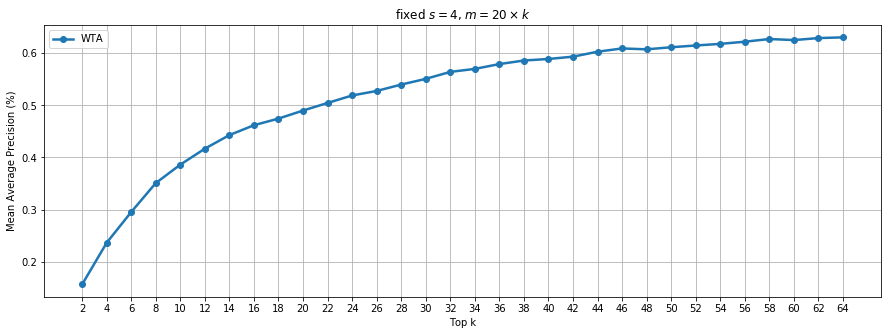

In [66]:
plt.figure(figsize=(15, 5))
plt.plot(k_arr_1, precision_wta_k_1, 'o-', linewidth=2.5, label='WTA')
plt.xticks(k_arr_1)
plt.grid()
plt.title('fixed $s = 4$, $m = 20 \\times k$')
plt.xlabel('Top k')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

#### fixed $s=4$, $m = 10 \times d$, $k$ from $2$ to $64$

In [67]:
s = 4
k_arr_2 = np.arange(2, 66, 2)
m = 10 * d

In [68]:
%%time
precision_wta_k_2 = []
for k in k_arr_2:
    precision_wta_k_2.append(test_precision(train_center, test_center, 
                                        s, m, k, wta=True,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 21min 21s, sys: 53.6 s, total: 22min 15s
Wall time: 11min 41s


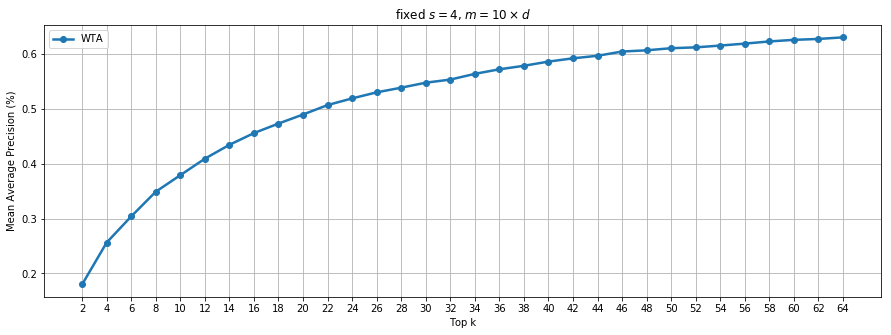

In [69]:
plt.figure(figsize=(15, 5))
plt.plot(k_arr_2, precision_wta_k_2, 'o-', linewidth=2.5, label='WTA')
plt.xticks(k_arr_2)
plt.grid()
plt.title('fixed $s = 4$, $m = 10 \\times d$')
plt.xlabel('Top k')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

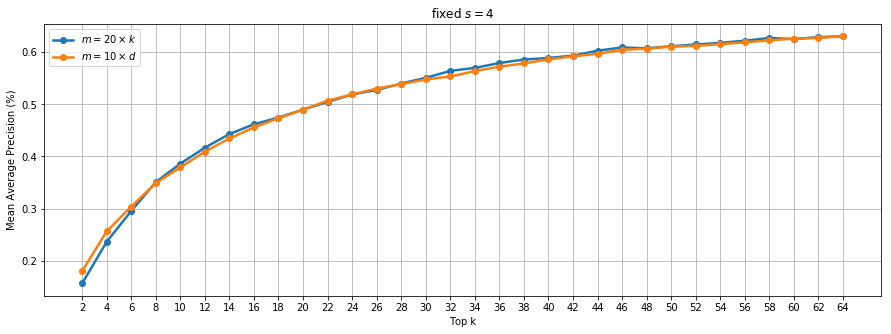

In [70]:
plt.figure(figsize=(15, 5))
plt.plot(k_arr_1, precision_wta_k_1, 'o-', linewidth=2.5, label='$m = 20 \\times k$')
plt.plot(k_arr_2, precision_wta_k_2, 'o-', linewidth=2.5, label='$m = 10 \\times d$')
plt.xticks(k_arr_2)
plt.grid()
plt.title('fixed $s = 4$')
plt.xlabel('Top k')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

### test: winner-take-all TYPE 2

**when**
$$
z_i = 
\begin{cases}
1, & \text{if $y_i$ is one of the $k$ largest entries in $y$} \\
0, & \text{otherwise}
\end{cases}
$$

#### fixed $s = 4$, $m = 20 \times k$, $k$ from $2$ to $64$

In [71]:
s = 4
k_arr_1 = np.arange(2, 66, 2)

In [72]:
%%time
precision_wta_indices_k_1 = []
for k in k_arr_1:
    m = 20 * k
    precision_wta_indices_k_1.append(test_precision(train_center, test_center, 
                                        s, m, k, wta=True, use_indices=True,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 19min 35s, sys: 48.7 s, total: 20min 23s
Wall time: 10min 32s


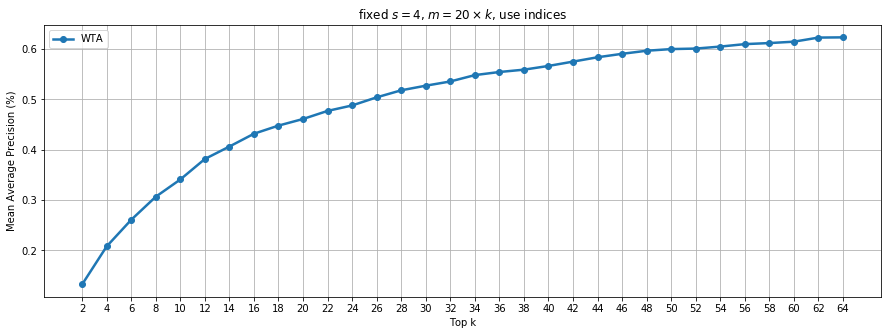

In [73]:
plt.figure(figsize=(15, 5))
plt.plot(k_arr_1, precision_wta_indices_k_1, 'o-', linewidth=2.5, label='WTA')
plt.xticks(k_arr_1)
plt.grid()
plt.title('fixed $s = 4$, $m = 20 \\times k$, use indices')
plt.xlabel('Top k')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

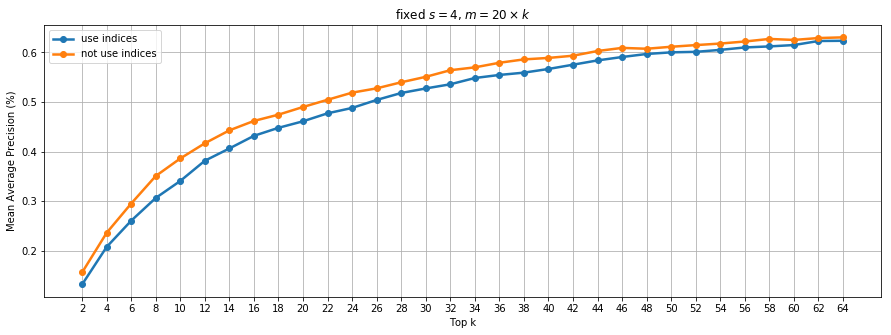

In [74]:
plt.figure(figsize=(15, 5))
plt.plot(k_arr_1, precision_wta_indices_k_1, 'o-', linewidth=2.5, label='use indices')
plt.plot(k_arr_1, precision_wta_k_1, 'o-', linewidth=2.5, label='not use indices')

plt.xticks(k_arr_1)
plt.grid()
plt.title('fixed $s = 4$, $m = 20 \\times k$')
plt.xlabel('Top k')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

#### fixed $s=4$, $m = 10 \times d$, $k$ from $2$ to $64$

In [75]:
s = 4
k_arr_2 = np.arange(2, 66, 2)
m = 10 * d

In [76]:
%%time
precision_wta_indices_k_2 = []
for k in k_arr_2:
    precision_wta_indices_k_2.append(test_precision(train_center, test_center, 
                                        s, m, k, wta=True, use_indices=True,
                                        near_neighbors=k_near_neighbors, random_state=1))

CPU times: user 20min 48s, sys: 51.2 s, total: 21min 39s
Wall time: 11min 15s


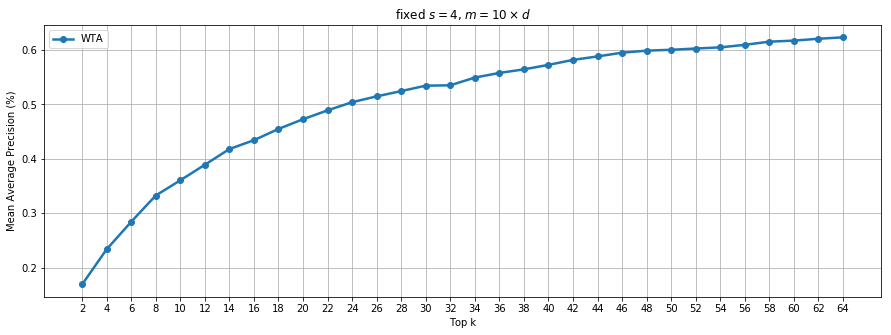

In [77]:
plt.figure(figsize=(15, 5))
plt.plot(k_arr_2, precision_wta_indices_k_2, 'o-', linewidth=2.5, label='WTA')
plt.xticks(k_arr_2)
plt.grid()
plt.title('fixed $s = 4$, $m = 10 \\times d$')
plt.xlabel('Top k')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

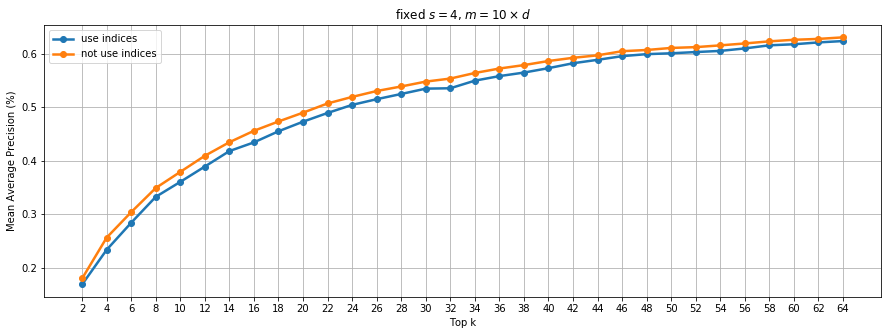

In [78]:
plt.figure(figsize=(15, 5))
plt.plot(k_arr_1, precision_wta_indices_k_2, 'o-', linewidth=2.5, label='use indices')
plt.plot(k_arr_1, precision_wta_k_2, 'o-', linewidth=2.5, label='not use indices')

plt.xticks(k_arr_1)
plt.grid()
plt.title('fixed $s = 4$, $m = 10 \\times d$')
plt.xlabel('Top k')
plt.ylabel('Mean Average Precision (%)')
plt.legend()
plt.show()

---